## Load and Prepare Data


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sktime.split import temporal_train_test_split
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb

import warnings

warnings.filterwarnings("ignore")

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Data path
DATA_PATH = Path(
    "/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/practical-ml-psl/0_data/bissau_merged.nc"
)

# Center cell indices (for 5x5 grid)
CENTER_LAT_IDX = 2
CENTER_LON_IDX = 2

# Rain threshold (mm)
RAIN_THRESHOLD = 0.1

print(f"Data path: {DATA_PATH}")
print(f"Rain threshold: {RAIN_THRESHOLD} mm")

Data path: /Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/practical-ml-psl/0_data/bissau_merged.nc
Rain threshold: 0.1 mm


In [3]:
# Load NetCDF4 with xarray
ds = xr.open_dataset(DATA_PATH)

# Convert timestamps to datetime
time_values = pd.to_datetime(ds.valid_time.values)

# Extract center cell data & apply unit conversions
t2m_center = ds.t2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
d2m_center = ds.d2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
tcc_center = ds.tcc[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 100  # fraction → %
sp_center = ds.sp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values / 100  # Pa → hPa
tp_center = ds.tp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 1000  # m → mm

# Create DataFrame with datetime index
df = pd.DataFrame(
    {
        "datetime": time_values,
        "t2m": t2m_center,  # Temperature (°C)
        "d2m": d2m_center,  # Dewpoint (°C)
        "tcc": tcc_center,  # Cloud cover (%)
        "sp": sp_center,  # Surface pressure (hPa)
        "tp": tp_center,  # Precipitation (mm)
    }
)
df.set_index("datetime", inplace=True)


# Calculate Relative Humidity using Magnus formula
def calc_relative_humidity(t2m, d2m):
    a, b = 17.625, 243.04
    rh = 100 * np.exp((a * d2m) / (b + d2m)) / np.exp((a * t2m) / (b + t2m))
    return np.clip(rh, 0, 100)


df["rh"] = calc_relative_humidity(df["t2m"].values, df["d2m"].values)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nBasic statistics:")
df.describe().round(2)

Data shape: (18263, 6)
Date range: 1975-01-01 00:00:00 to 2024-12-31 00:00:00

Basic statistics:


,t2m,d2m,tcc,sp,tp,rh
count,18263.00,18263.00,18263.00,18263.00,18263.00,18263.00
mean,24.93,20.85,56.09,1011.19,0.10,79.89
std,1.64,4.56,40.24,1.63,0.53,16.09
min,18.62,0.08,0.00,1005.20,0.00,21.22
25%,23.99,19.05,10.79,1010.07,0.00,74.01
50%,25.13,22.68,66.50,1011.18,0.00,86.25
75%,26.07,24.03,97.31,1012.32,0.00,91.38
max,31.38,27.67,100.00,1017.49,24.93,99.86


## Binarize Target Variable

Create binary target: Rain (tp > 0.1mm) vs No Rain


BINARY TARGET DISTRIBUTION (threshold: 0.1 mm)

No Rain (0): 16,284 days (89.2%)
Rain (1):    1,979 days (10.8%)

Class imbalance ratio: 8.23:1


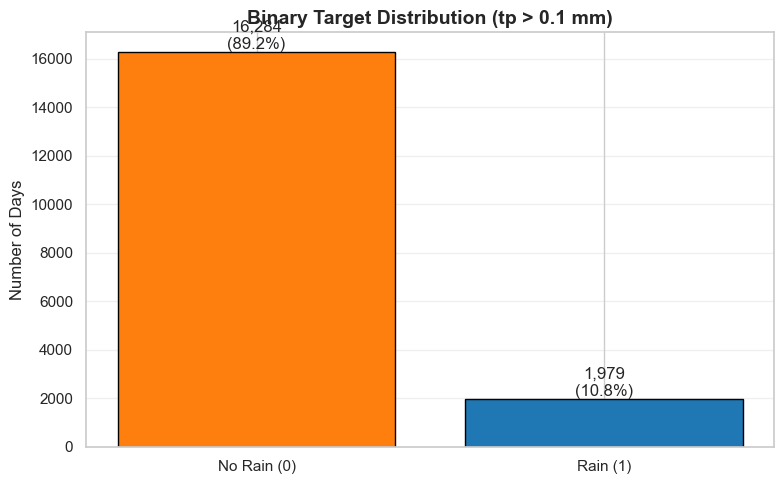

In [4]:
# Binarize precipitation: Rain vs No Rain
df["rain_binary"] = (df["tp"] > RAIN_THRESHOLD).astype(int)

# Check class distribution
class_counts = df["rain_binary"].value_counts()
class_pct = df["rain_binary"].value_counts(normalize=True) * 100

print("=" * 50)
print(f"BINARY TARGET DISTRIBUTION (threshold: {RAIN_THRESHOLD} mm)")
print("=" * 50)
print(f"\nNo Rain (0): {class_counts[0]:,} days ({class_pct[0]:.1f}%)")
print(f"Rain (1):    {class_counts[1]:,} days ({class_pct[1]:.1f}%)")
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#ff7f0e", "#1f77b4"]
bars = ax.bar(
    ["No Rain (0)", "Rain (1)"], class_counts.values, color=colors, edgecolor="black"
)
ax.bar_label(
    bars,
    labels=[
        f"{c:,}\n({p:.1f}%)" for c, p in zip(class_counts.values, class_pct.values)
    ],
)
ax.set_ylabel("Number of Days")
ax.set_title(
    f"Binary Target Distribution (tp > {RAIN_THRESHOLD} mm)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Engineering

Add temporal features:

- Lag features (1, 2, 3, 7 days)
- Rolling statistics (7-day, 30-day mean/std)
- Lag 1 year (365 days)
- Lag 1 year rolling average


In [5]:
def create_lag_features(df, base_features, lags=[1, 2, 3, 7]):
    """Create lag features for specified columns."""
    df_feat = df.copy()
    for feat in base_features:
        for lag in lags:
            df_feat[f"{feat}_lag{lag}"] = df_feat[feat].shift(lag)
    return df_feat


def create_rolling_features(df, base_features, windows=[7, 30]):
    """Create rolling mean and std features."""
    df_feat = df.copy()
    for feat in base_features:
        for window in windows:
            df_feat[f"{feat}_rollmean{window}"] = (
                df_feat[feat].shift(1).rolling(window).mean()
            )
            df_feat[f"{feat}_rollstd{window}"] = (
                df_feat[feat].shift(1).rolling(window).std()
            )
    return df_feat


def create_yearly_lag_features(df, base_features):
    """Create lag 1 year and lag 1 year rolling average features."""
    df_feat = df.copy()
    for feat in base_features:
        # Lag 1 year (365 days)
        df_feat[f"{feat}_lag365"] = df_feat[feat].shift(365)
        # Lag 1 year rolling average (centered around same day last year)
        df_feat[f"{feat}_lag365_rollmean30"] = (
            df_feat[feat].shift(365).rolling(30, center=True).mean()
        )
    return df_feat


# Base meteorological features
base_features = ["tp", "t2m", "d2m", "rh", "sp"]

# Apply feature engineering
print("Creating lag features...")
df_features = create_lag_features(df, base_features, lags=[1, 2, 3, 7])

print("Creating rolling features...")
df_features = create_rolling_features(df_features, base_features, windows=[7, 30])

print("Creating yearly lag features...")
df_features = create_yearly_lag_features(df_features, base_features)

# Add day of year for seasonality
df_features["day_of_year"] = df_features.index.dayofyear
df_features["month"] = df_features.index.month

# Drop rows with NaN (due to lagging/rolling)
df_clean = df_features.dropna()

print(f"\nOriginal shape: {df.shape}")
print(f"After feature engineering: {df_features.shape}")
print(f"After dropping NaN: {df_clean.shape}")
print(
    f"Days removed: {len(df) - len(df_clean)} (due to lag/rolling window requirements)"
)

Creating lag features...
Creating rolling features...
Creating yearly lag features...

Original shape: (18263, 7)
After feature engineering: (18263, 59)
After dropping NaN: (17869, 59)
Days removed: 394 (due to lag/rolling window requirements)


In [6]:
# Define feature columns (exclude target and original tp)
exclude_cols = ["tp", "rain_binary"]
feature_columns = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Total features: {len(feature_columns)}")
print(f"\nFeature categories:")
print(f"  - Base features: {len(base_features)}")
print(
    f"  - Lag features: {len([c for c in feature_columns if 'lag' in c and 'roll' not in c])}"
)
print(
    f"  - Rolling features: {len([c for c in feature_columns if 'roll' in c and 'lag365' not in c])}"
)
print(f"  - Yearly features: {len([c for c in feature_columns if 'lag365' in c])}")

print(f"\nAll features:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Total features: 57

Feature categories:
  - Base features: 5
  - Lag features: 25
  - Rolling features: 20
  - Yearly features: 10

All features:
   1. t2m
   2. d2m
   3. tcc
   4. sp
   5. rh
   6. tp_lag1
   7. tp_lag2
   8. tp_lag3
   9. tp_lag7
  10. t2m_lag1
  11. t2m_lag2
  12. t2m_lag3
  13. t2m_lag7
  14. d2m_lag1
  15. d2m_lag2
  16. d2m_lag3
  17. d2m_lag7
  18. rh_lag1
  19. rh_lag2
  20. rh_lag3
  21. rh_lag7
  22. sp_lag1
  23. sp_lag2
  24. sp_lag3
  25. sp_lag7
  26. tp_rollmean7
  27. tp_rollstd7
  28. tp_rollmean30
  29. tp_rollstd30
  30. t2m_rollmean7
  31. t2m_rollstd7
  32. t2m_rollmean30
  33. t2m_rollstd30
  34. d2m_rollmean7
  35. d2m_rollstd7
  36. d2m_rollmean30
  37. d2m_rollstd30
  38. rh_rollmean7
  39. rh_rollstd7
  40. rh_rollmean30
  41. rh_rollstd30
  42. sp_rollmean7
  43. sp_rollstd7
  44. sp_rollmean30
  45. sp_rollstd30
  46. tp_lag365
  47. tp_lag365_rollmean30
  48. t2m_lag365
  49. t2m_lag365_rollmean30
  50. d2m_lag365
  51. d2m_lag365_rollmean

## Temporal Train/Val/Test Split (70/20/10)

Using sktime's `temporal_train_test_split` to preserve time ordering.


In [7]:
# Prepare X and y
X = df_clean[feature_columns]
y = df_clean["rain_binary"]

# Calculate split sizes
total = len(df_clean)
train_size = int(total * 0.70)
val_size = int(total * 0.20)
test_size = total - train_size - val_size  # Remainder (~10%)

print(f"Total samples: {total:,}")
print(f"\nPlanned split:")
print(f"  Train: {train_size:,} ({train_size/total*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/total*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/total*100:.1f}%)")

Total samples: 17,869

Planned split:
  Train: 12,508 (70.0%)
  Val:   3,573 (20.0%)
  Test:  1,788 (10.0%)


In [8]:
# First split: train vs (val + test)
y_train, y_temp = temporal_train_test_split(y, test_size=(val_size + test_size))
X_train, X_temp = temporal_train_test_split(X, test_size=(val_size + test_size))

# Second split: val vs test
y_val, y_test = temporal_train_test_split(y_temp, test_size=test_size)
X_val, X_test = temporal_train_test_split(X_temp, test_size=test_size)

print("=" * 60)
print("TEMPORAL SPLIT RESULTS")
print("=" * 60)
print(f"\nTrain set: {len(X_train):,} samples ({len(X_train)/total*100:.1f}%)")
print(f"  Date range: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"  Rain days: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")

print(f"\nValidation set: {len(X_val):,} samples ({len(X_val)/total*100:.1f}%)")
print(f"  Date range: {X_val.index.min().date()} to {X_val.index.max().date()}")
print(f"  Rain days: {y_val.sum():,} ({y_val.mean()*100:.1f}%)")

print(f"\nTest set: {len(X_test):,} samples ({len(X_test)/total*100:.1f}%)")
print(f"  Date range: {X_test.index.min().date()} to {X_test.index.max().date()}")
print(f"  Rain days: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")

TEMPORAL SPLIT RESULTS

Train set: 12,508 samples (70.0%)
  Date range: 1976-01-16 to 2010-04-14
  Rain days: 1,333 (10.7%)

Validation set: 3,573 samples (20.0%)
  Date range: 2010-04-15 to 2020-01-25
  Rain days: 365 (10.2%)

Test set: 1,788 samples (10.0%)
  Date range: 2020-01-26 to 2024-12-17
  Rain days: 226 (12.6%)


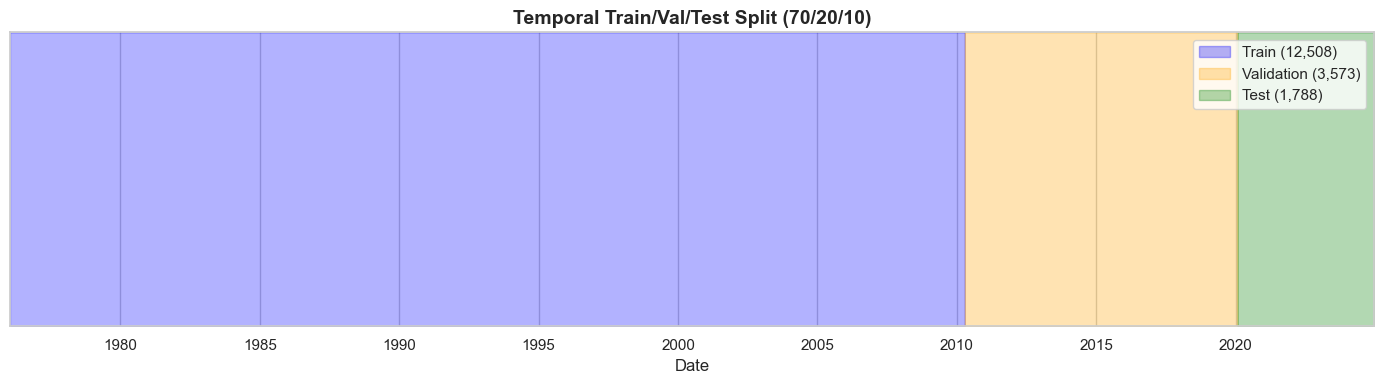

In [9]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))

ax.fill_between(
    X_train.index, 0, 1, alpha=0.3, color="blue", label=f"Train ({len(X_train):,})"
)
ax.fill_between(
    X_val.index, 0, 1, alpha=0.3, color="orange", label=f"Validation ({len(X_val):,})"
)
ax.fill_between(
    X_test.index, 0, 1, alpha=0.3, color="green", label=f"Test ({len(X_test):,})"
)

ax.set_xlim(df_clean.index.min(), df_clean.index.max())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Date")
ax.set_title("Temporal Train/Val/Test Split (70/20/10)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## XGBoost Model

Train an XGBoost classifier with scale_pos_weight for class imbalance handling.


In [10]:
# XGBoost Model Training with Hyperparameter Tuning

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight (for class imbalance): {scale_pos_weight:.2f}")

# Define hyperparameter grid for XGBoost (focused search)
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
}

# Use TimeSeriesSplit for proper time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Create base XGBoost model with fixed scale_pos_weight
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="auc",
    n_jobs=-1,
    verbosity=0,
)

# Use RandomizedSearchCV for efficiency
grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,  # Try 100 random combinations
    cv=tscv,  # Time series cross-validation (no shuffling!)
    scoring="f1",  # Optimize for F1 score due to imbalance
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

print("=" * 60)
print("XGBOOST HYPERPARAMETER TUNING")
print("=" * 60)
print(f"Randomized search iterations: {grid_search.n_iter}")
print(
    f"Cross-validation: TimeSeriesSplit with {tscv.n_splits} splits (temporal order preserved)"
)
print(f"Scoring metric: {grid_search.scoring}")
print(f"\nStarting hyperparameter search...")

# Fit the model on training data
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {grid_search.best_score_:.4f}")

# Get the best model
best_xgb = grid_search.best_estimator_

Scale pos weight (for class imbalance): 8.38
XGBOOST HYPERPARAMETER TUNING
Randomized search iterations: 100
Cross-validation: TimeSeriesSplit with 3 splits (temporal order preserved)
Scoring metric: f1

Starting hyperparameter search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits

Best parameters found:
  n_estimators: 100
  max_depth: 7
  learning_rate: 0.05

Best cross-validation F1 score: 0.5922


In [11]:
# Model Evaluation

# Predictions using best model
y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:, 1]

y_val_pred = best_xgb.predict(X_val)
y_val_proba = best_xgb.predict_proba(X_val)[:, 1]

y_test_pred = best_xgb.predict(X_test)
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]

# Calculate metrics
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=" * 60)
print("XGBOOST RESULTS (TUNED)")
print("=" * 60)
print(f"\n{'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print("-" * 45)
print(f"{'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"{'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"{'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")

XGBOOST RESULTS (TUNED)

Set            Accuracy   F1 Score    ROC AUC
---------------------------------------------
Train            0.9123     0.7085     0.9874
Validation       0.8847     0.5708     0.9251
Test             0.8965     0.6122     0.9294


In [12]:
# Classification reports
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - VALIDATION SET")
print("=" * 60)
print(
    classification_report(y_val, y_val_pred, target_names=["No Rain (0)", "Rain (1)"])
)

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 60)
print(
    classification_report(y_test, y_test_pred, target_names=["No Rain (0)", "Rain (1)"])
)

# Feature Importance
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_xgb.feature_importances_}
).sort_values("importance", ascending=False)

print("\n" + "=" * 60)
print("TOP 20 FEATURE IMPORTANCES")
print("=" * 60)
print(feature_importance.head(20).to_string(index=False))


CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

 No Rain (0)       0.97      0.90      0.93      3208
    Rain (1)       0.46      0.75      0.57       365

    accuracy                           0.88      3573
   macro avg       0.71      0.83      0.75      3573
weighted avg       0.92      0.88      0.90      3573


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

 No Rain (0)       0.95      0.93      0.94      1562
    Rain (1)       0.58      0.65      0.61       226

    accuracy                           0.90      1788
   macro avg       0.76      0.79      0.78      1788
weighted avg       0.90      0.90      0.90      1788


TOP 20 FEATURE IMPORTANCES
              feature  importance
         tp_rollmean7    0.522679
          tp_rollstd7    0.064256
                  tcc    0.037483
                  t2m    0.018296
d2m_lag365_rollmean30    0.012455
 tp_lag365_rollmean30    0.011340
      

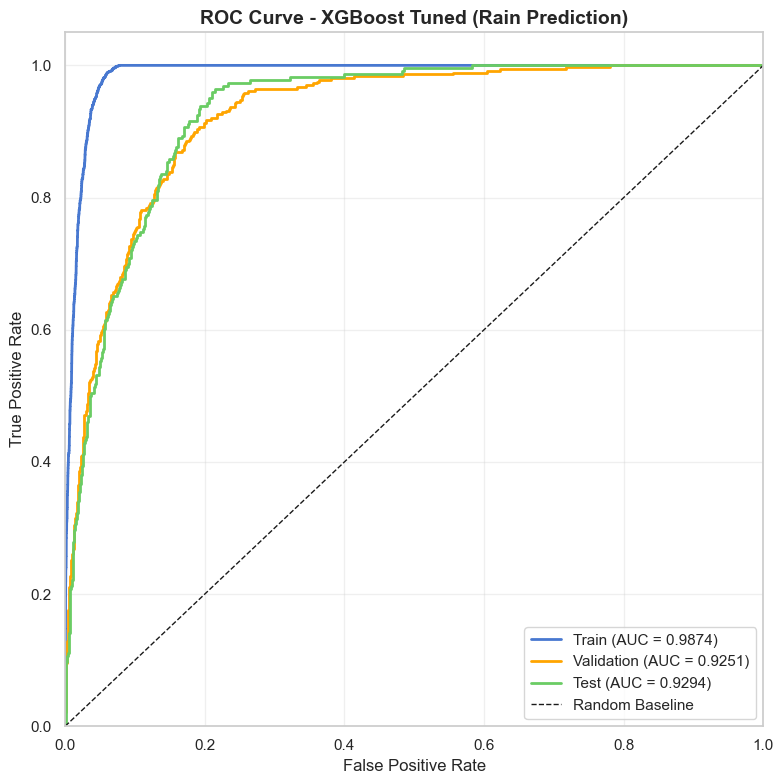

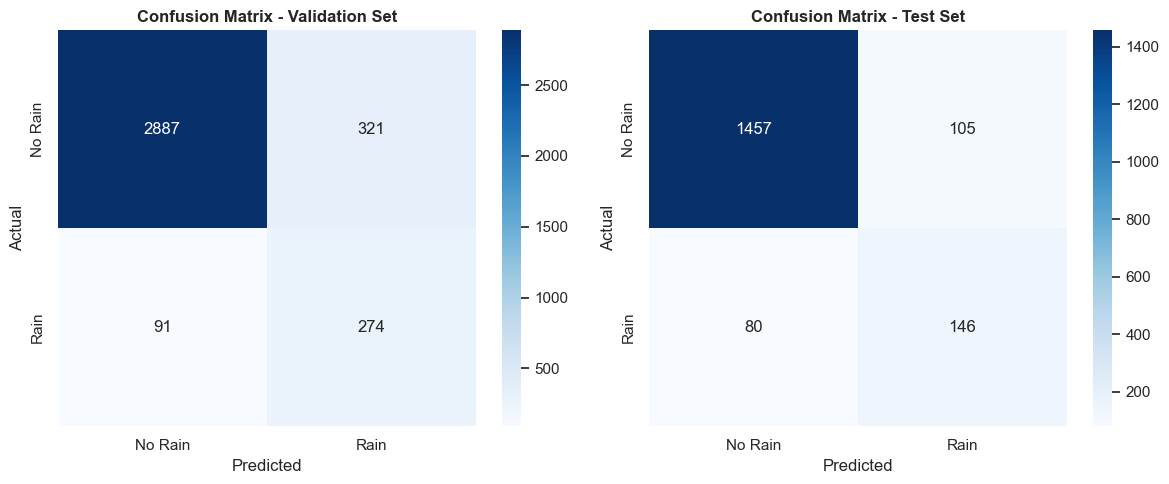

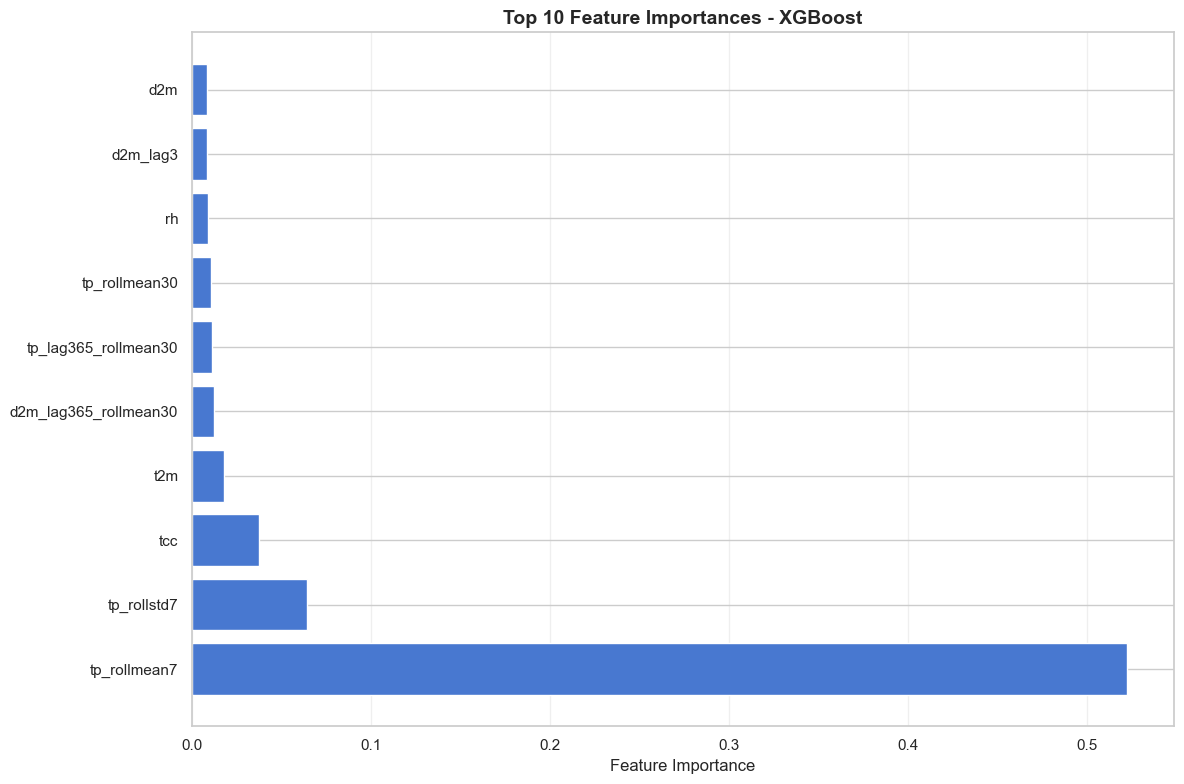

In [13]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 8))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
ax.plot(fpr_train, tpr_train, "b-", lw=2, label=f"Train (AUC = {train_auc:.4f})")

# Validation ROC
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
ax.plot(fpr_val, tpr_val, "orange", lw=2, label=f"Validation (AUC = {val_auc:.4f})")

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
ax.plot(fpr_test, tpr_test, "g-", lw=2, label=f"Test (AUC = {test_auc:.4f})")

# Random baseline
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random Baseline")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title(
    "ROC Curve - XGBoost Tuned (Rain Prediction)", fontsize=14, fontweight="bold"
)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_true, y_pred_set, title) in zip(
    axes, [(y_val, y_val_pred, "Validation"), (y_test, y_test_pred, "Test")]
):
    cm = confusion_matrix(y_true, y_pred_set)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        xticklabels=["No Rain", "Rain"],
        yticklabels=["No Rain", "Rain"],
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {title} Set", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# Feature importance plot
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features["importance"])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["feature"])
ax.set_xlabel("Feature Importance")
ax.set_title("Top 10 Feature Importances - XGBoost", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Importance

Analyze which features are most important for predicting rain using XGBoost's built-in feature importance.


In [14]:
# Cross-validation results analysis
cv_results = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameter combinations
print("=" * 60)
print("TOP 10 PARAMETER COMBINATIONS (by mean F1 score)")
print("=" * 60)

top_results = cv_results.nsmallest(10, "rank_test_score")[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
]
for idx, row in top_results.iterrows():
    print(f"\nRank {row['rank_test_score']}:")
    print(f"  Mean F1: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    for param, value in row["params"].items():
        print(f"    {param}: {value}")

TOP 10 PARAMETER COMBINATIONS (by mean F1 score)

Rank 1:
  Mean F1: 0.5922 (+/- 0.0193)
    n_estimators: 100
    max_depth: 7
    learning_rate: 0.05

Rank 2:
  Mean F1: 0.5889 (+/- 0.0049)
    n_estimators: 100
    max_depth: 10
    learning_rate: 0.05

Rank 3:
  Mean F1: 0.5868 (+/- 0.0213)
    n_estimators: 500
    max_depth: 7
    learning_rate: 0.01

Rank 4:
  Mean F1: 0.5856 (+/- 0.0099)
    n_estimators: 200
    max_depth: 7
    learning_rate: 0.05

Rank 5:
  Mean F1: 0.5835 (+/- 0.0046)
    n_estimators: 500
    max_depth: 10
    learning_rate: 0.01

Rank 6:
  Mean F1: 0.5829 (+/- 0.0245)
    n_estimators: 300
    max_depth: 7
    learning_rate: 0.01

Rank 7:
  Mean F1: 0.5796 (+/- 0.0058)
    n_estimators: 300
    max_depth: 10
    learning_rate: 0.01

Rank 8:
  Mean F1: 0.5777 (+/- 0.0235)
    n_estimators: 200
    max_depth: 7
    learning_rate: 0.01

Rank 9:
  Mean F1: 0.5774 (+/- 0.0051)
    n_estimators: 100
    max_depth: 7
    learning_rate: 0.1

Rank 10:
  Mean F1: 0

## Prediction Visualization

Visualize the model predictions on the test set.


Showing predictions for: 2023-12-17 to 2024-12-17
Total days shown: 367


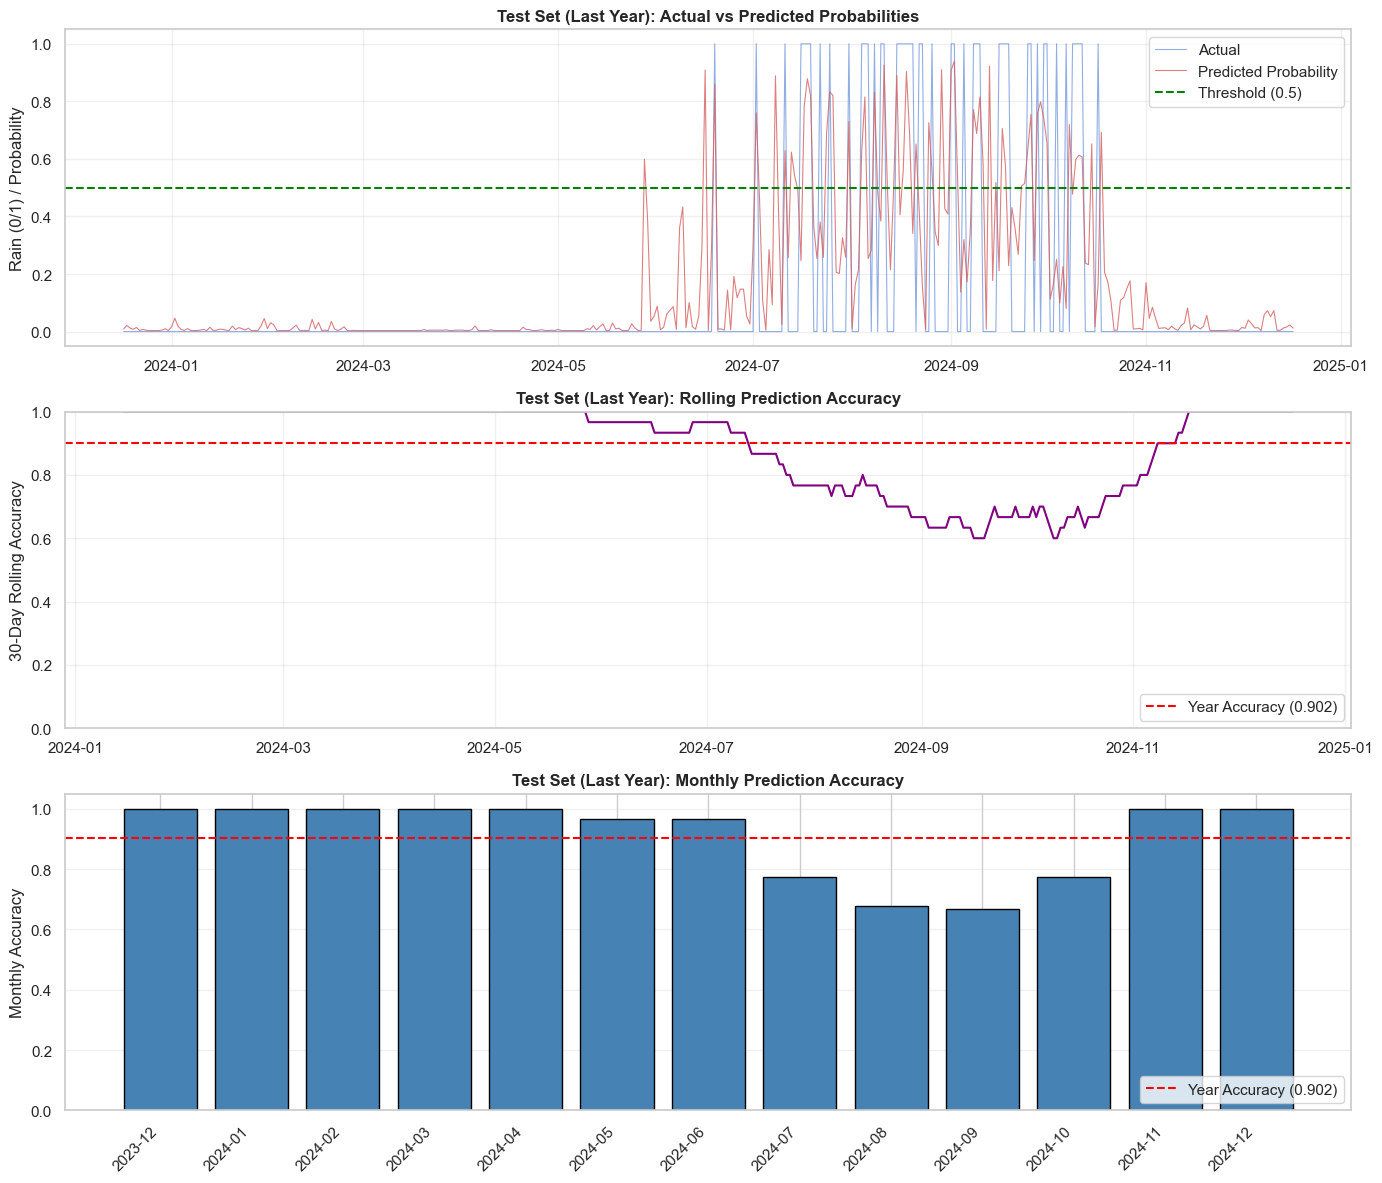

In [15]:
# Plot predictions over time for test set (last year only)
# Filter to show only the last year of predictions for better visibility
last_year_start = X_test.index.max() - pd.DateOffset(years=1)
mask = X_test.index >= last_year_start

X_test_1yr = X_test[mask]
y_test_1yr = y_test[mask]
y_test_pred_1yr = y_test_pred[mask]
y_test_proba_1yr = y_test_proba[mask]

print(
    f"Showing predictions for: {X_test_1yr.index.min().date()} to {X_test_1yr.index.max().date()}"
)
print(f"Total days shown: {len(X_test_1yr)}")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Test set - actual vs predicted probabilities (1 year)
ax = axes[0]
ax.plot(
    X_test_1yr.index, y_test_1yr.values, "b-", alpha=0.6, label="Actual", linewidth=0.8
)
ax.plot(
    X_test_1yr.index,
    y_test_proba_1yr,
    "r-",
    alpha=0.8,
    label="Predicted Probability",
    linewidth=0.8,
)
ax.axhline(y=0.5, color="green", linestyle="--", label="Threshold (0.5)")
ax.set_ylabel("Rain (0/1) / Probability")
ax.set_title(
    "Test Set (Last Year): Actual vs Predicted Probabilities",
    fontsize=12,
    fontweight="bold",
)
ax.legend(loc="upper right")
ax.grid(alpha=0.3)

# Rolling accuracy over test period (30-day window) - 1 year
ax = axes[1]
correct_1yr = (y_test_1yr.values == y_test_pred_1yr).astype(int)
rolling_acc_1yr = pd.Series(correct_1yr, index=X_test_1yr.index).rolling(30).mean()
test_acc_1yr = accuracy_score(y_test_1yr, y_test_pred_1yr)
ax.plot(rolling_acc_1yr.index, rolling_acc_1yr.values, "purple", linewidth=1.5)
ax.axhline(
    y=test_acc_1yr,
    color="red",
    linestyle="--",
    label=f"Year Accuracy ({test_acc_1yr:.3f})",
)
ax.set_ylabel("30-Day Rolling Accuracy")
ax.set_title(
    "Test Set (Last Year): Rolling Prediction Accuracy", fontsize=12, fontweight="bold"
)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

# Monthly prediction accuracy - 1 year
ax = axes[2]
monthly_acc_1yr = pd.DataFrame(
    {"actual": y_test_1yr.values, "predicted": y_test_pred_1yr}, index=X_test_1yr.index
)
monthly_metrics_1yr = monthly_acc_1yr.groupby(
    monthly_acc_1yr.index.to_period("M")
).apply(lambda x: (x["actual"] == x["predicted"]).mean())
ax.bar(
    range(len(monthly_metrics_1yr)),
    monthly_metrics_1yr.values,
    color="steelblue",
    edgecolor="black",
)
ax.set_xticks(range(len(monthly_metrics_1yr)))
ax.set_xticklabels([str(p) for p in monthly_metrics_1yr.index], rotation=45, ha="right")
ax.axhline(
    y=test_acc_1yr,
    color="red",
    linestyle="--",
    label=f"Year Accuracy ({test_acc_1yr:.3f})",
)
ax.set_ylabel("Monthly Accuracy")
ax.set_title(
    "Test Set (Last Year): Monthly Prediction Accuracy", fontsize=12, fontweight="bold"
)
ax.legend(loc="lower right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Summary


In [16]:
print("=" * 70)
print("PRECIPITATION PREDICTION MODEL SUMMARY (XGBOOST - TUNED)")
print("=" * 70)
print(f"\nData:")
print(f"  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau")
print(f"  Period: {df_clean.index.min().date()} to {df_clean.index.max().date()}")
print(f"  Total samples: {len(df_clean):,} days")

print(f"\nTarget Variable:")
print(f"  Binary classification: Rain (tp > {RAIN_THRESHOLD} mm) vs No Rain")
print(f"  Class distribution: {df_clean['rain_binary'].mean()*100:.1f}% rain days")

print(f"\nFeatures: {len(feature_columns)} total")
print(f"  - Base meteorological: t2m, d2m, rh, sp")
print(f"  - Lag features: 1, 2, 3, 7 days")
print(f"  - Rolling statistics: 7-day and 30-day mean/std")
print(f"  - Yearly features: lag 365 days, lag 365 rolling mean")

print(f"\nModel: XGBoost Classifier (Hyperparameter Tuned)")
print(f"  - Tuning method: RandomizedSearchCV with TimeSeriesSplit")
print(f"  - CV splits: {tscv.n_splits}")
print(f"  - Iterations: {grid_search.n_iter}")
print(f"  - scale_pos_weight: {scale_pos_weight:.2f}")
print(f"  - Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"      {param}: {value}")

print(f"\nResults:")
print(f"  {'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print(f"  {'-'*45}")
print(f"  {'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"  {'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"  {'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")

print(f"\nModel Performance:")
print(f"  Best CV F1 Score: {grid_search.best_score_:.4f}")

PRECIPITATION PREDICTION MODEL SUMMARY (XGBOOST - TUNED)

Data:
  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau
  Period: 1976-01-16 to 2024-12-17
  Total samples: 17,869 days

Target Variable:
  Binary classification: Rain (tp > 0.1 mm) vs No Rain
  Class distribution: 10.8% rain days

Features: 57 total
  - Base meteorological: t2m, d2m, rh, sp
  - Lag features: 1, 2, 3, 7 days
  - Rolling statistics: 7-day and 30-day mean/std
  - Yearly features: lag 365 days, lag 365 rolling mean

Model: XGBoost Classifier (Hyperparameter Tuned)
  - Tuning method: RandomizedSearchCV with TimeSeriesSplit
  - CV splits: 3
  - Iterations: 100
  - scale_pos_weight: 8.38
  - Best parameters:
      n_estimators: 100
      max_depth: 7
      learning_rate: 0.05

Results:
  Set            Accuracy   F1 Score    ROC AUC
  ---------------------------------------------
  Train            0.9123     0.7085     0.9874
  Validation       0.8847     0.5708     0.9251
  Test             0.8965     0.6122     0.9